In [49]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

In [50]:
torch.manual_seed(2)
np.random.seed(2)

In [51]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100. 

#System parameters from deterministic CON model
u_M = 0.0009
a_SD = 0.5
a_DS = 0.5
a_M = 0.5
a_MSC = 0.5
k_S_ref = 0.0001
k_D_ref = 0.018
k_M_ref = 0.00022
Ea_S = 55
Ea_D = 48
Ea_M = 48

#SCON diffusion matrix parameters
c_SOC = 0.1
c_DOC = 0.001
c_MBC = 0.0005

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}
#SCON_SS_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC}

#System parameters from deterministic AWB model
#u_Q_ref = 0.2
#Q = 0.002
#a_MSA = 0.5
#K_D = 200
#K_U = 1
#V_D_ref = 0.4
#V_U_ref = 0.02
#Ea_V_D = 75
#Ea_V_U = 50
#r_M = 0.0004
#r_E = 0.00001
#r_L = 0.0005

#SAWB diffusion matrix parameters
#c_SOC = 2
#c_DOC = 0.05
#c_MBC = 0.1
#c_EEC = 0.01
#s_SOC = 0.1
#s_DOC = 0.1
#s_MBC = 0.1
#s_EEC = 0.1

#SAWB_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
#SAWB_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

#System parameters from deterministic AWB-ECA model
#u_Q_ref = 0.2
#Q = 0.002
#a_MSA = 0.5
#K_DE = 200
#K_UE = 1
#V_DE_ref = 0.4
#V_UE_ref = 0.02
#Ea_V_DE = 75
#Ea_V_UE = 50
#r_M = 0.0004
#r_E = 0.00001
#r_L = 0.0005

#SAWB-ECA diffusion matrix parameters
#c_SOC = 2
#c_DOC = 0.05
#c_MBC = 0.1
#c_EEC = 0.01
#s_SOC = 0.1
#s_DOC = 0.1
#s_MBC = 0.1
#s_EEC = 0.1

#SAWB_ECA_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
#SAWB_ECA_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

In [52]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [53]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])
    
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < 1e-6] = 1e-6 #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    hour = 0
    for i in range(1, N):
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, temp_ref, temp_rise)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < 1e-6] = 1e-6 #Bound all x above 0.
        #print('x at i', x[:, i])
        hour += DT
        #print('hour', hour)
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < 1e-6] = 1e-6 #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'x': x, 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < 1e-6] = 1e-6 #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample 
    hour = 0
    for i in range(1, N):
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, temp_ref, temp_rise)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < 1e-6] = 1e-6 #Bound all x above 0.
        #print('x at i', x[:, i])
        hour += DT
        #print('hour', hour)
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < 1e-6] = 1e-6 #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'x': x, 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

In [54]:
dt = 0.01
t = 8760
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1

In [55]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_C, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

X0_sample =  [62.29107399  0.39774933  1.96595098]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


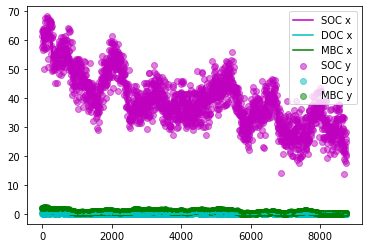

In [56]:
fig, axs = plt.subplots(1, 1)
axs.plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs.plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs.plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs.scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.5, label = 'SOC y')
axs.scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.5, label = 'DOC y')
axs.scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.5, label = 'MBC y')
axs.legend()

In [57]:
fig_save_string = f't_{t}_dt_{dt}'.replace('.','-')
fig.savefig(fig_save_string, dpi = 300)

<ipython-input-57-f4246d24a0a8>:2: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(fig_save_string, dpi = 300)


In [58]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :]})
df_y.to_csv(f'y_from_x_t_{t}_dt_{dt}'.replace('.','-') + '.csv', index = False)

In [59]:
print(df_y)

        hour        SOC       DOC       MBC
0        0.0  57.642345  0.388805  2.010929
1        5.0  63.160908  0.301657  2.055717
2       10.0  61.203829  0.292827  2.001701
3       15.0  59.544921  0.165533  1.941606
4       20.0  56.677398  0.107767  1.867841
...      ...        ...       ...       ...
1748  8740.0  25.977272  0.043675  0.480857
1749  8745.0  28.142827  0.125910  0.298510
1750  8750.0  24.742378  0.094460  0.330822
1751  8755.0  20.677956  0.072496  0.357468
1752  8760.0  20.129210  0.015962  0.276501

[1753 rows x 4 columns]


In [60]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

X0_sample =  [64.12052181  0.36097231  2.76930635]


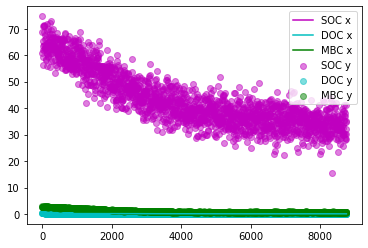

In [61]:
fig2, axs2 = plt.subplots(1, 1)
axs2.plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2.plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2.plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2.scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.5, label = 'SOC y')
axs2.scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.5, label = 'DOC y')
axs2.scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.5, label = 'MBC y')
axs2.legend()

In [62]:
fig2_save_string = f't_{t}_dt_{dt}_det'.replace('.','-')
fig2.savefig(fig2_save_string, dpi = 300)

In [63]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :]})
df_y_det.to_csv(f'y_from_x_t_{t}_dt_{dt}'.replace('.','-') + '.csv', index = False)

In [64]:
print(df_y_det)

        hour        SOC       DOC       MBC
0        0.0  60.851567  0.366448  2.808999
1        5.0  74.689949  0.345210  2.984173
2       10.0  68.768725  0.296578  2.789180
3       15.0  71.151122  0.307644  2.821594
4       20.0  59.297258  0.299860  2.628377
...      ...        ...       ...       ...
1748  8740.0  32.263399  0.089893  0.604660
1749  8745.0  30.347613  0.082339  0.542788
1750  8750.0  34.638412  0.115730  0.685892
1751  8755.0  34.994566  0.106325  0.650550
1752  8760.0  41.000862  0.081168  0.693168

[1753 rows x 4 columns]
